In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
import pandas as pd

# Read all sheets
excel_path = "IS453 Group Assignment - Data Dict.xlsx"
xls = pd.ExcelFile(excel_path)

# Display sheet names
print(xls.sheet_names)

# Read each sheet into a DataFrame
df1 = pd.read_excel(xls, xls.sheet_names[0])
df2 = pd.read_excel(xls, xls.sheet_names[1])

# Display basic info
print("Sheet 1 shape:", df1.shape)
print("Sheet 2 shape:", df2.shape)

['Application Data', 'Bureau Data']
Sheet 1 shape: (120, 3)
Sheet 2 shape: (17, 3)


In [58]:

# This was after preprocessing of removing applicant below 60 years
main_df = pd.read_csv("elder_care_segment.csv")

In [59]:
main_df["NAME_INCOME_TYPE"].unique()

array(['Pensioner', 'Working', 'Commercial associate', 'State servant',
       'Unemployed', 'Maternity leave'], dtype=object)

In [60]:
import pandas as pd
df = pd.read_csv("merged_applicant_and_bureau.csv")

In [61]:
df.shape

(254368, 29)

In [62]:
df["AMT_INCOME_TOTAL"].min()

np.float64(25650.0)

In [63]:
# No individual with income below $20,000
main_df = df[df["AMT_INCOME_TOTAL"] >= 20000]
main_df = main_df.drop(columns=["AMT_CREDIT_SUM_mean"])
main_df.shape

(254368, 28)

### Filtering Methodology Based on Two Core Axioms

We will be filtering our dataset based on two widely accepted axioms to ensure our analysis reflects the realistic characteristics of our target population and lending environment:

1. **Axiom 1: Care Recipients’ Age Range (75–90 years old)**
   Individuals who typically require caregiving support fall between the ages of **75 to 90**. According to [NCOA research](https://www.ncoa.org/article/get-the-facts-on-economic-security-for-seniors/), this demographic is more likely to experience declining health, limited income, and increased dependence on external care.

   * **Implication:** Our **target audience** (the caregivers) are thus most likely their adult children or close relatives aged **30 to 65**, forming the relevant segment for assessing loan needs or default risk.
   * **Rationale:** This age-based filtering ensures that the model focuses on the population most relevant to caregiving-related financial needs, avoiding bias from unrelated age groups (e.g., younger individuals with different financial behavior).

2. **Axiom 2: Loan Amount Should Not Exceed $75,000**
   The typical amount needed for an individual caregiving-related loan (e.g., medical expenses, assistive equipment, or home modifications) [rarely exceeds **$75,000**](https://www.shriramfinance.in/article-your-comprehensive-guide-on-navigating-personal-loans-for-senior-citizens). Larger loans are generally business- or investment-related and not representative of personal caregiving financial needs.

   * **Implication:** The variable `CREDIT_SUM_mean` becomes less useful in its raw form, as its distribution may be **artificially skewed** by extremely high loan amounts that do not correspond to our target use case, hence John has elected to drop it, and since he might be the only one reading this, it has been dropped.
   * **Rationale:** By applying this cap, we maintain the interpretability and stability of the model features while ensuring the data reflects realistic loan amounts for the target demographic.

---

### Why We Do **Not** Fully Filter Out Individuals With Large Loans

While some individuals may have loans exceeding $75,000, we **do not remove the entire individual record** outright. Instead, we **filter out only those specific loan entries** that surpass the defined threshold.

The reasoning is based on preserving data diversity and model fairness:

* A single individual may hold multiple loans across varying purposes and amounts — removing them entirely would **unnecessarily reduce valid observations**.
* Filtering only outlier **loan records** (rather than entire borrowers) **prevents distortion** caused by a few extreme transactions while retaining the individual’s typical borrowing behavior for analysis.
* This approach maintains **representative borrower patterns** across realistic loan ranges, which is crucial for generalization in scorecard modeling.

---

### Rationale for the Filtering Methodology

1. **Remove Outlier Records (Preferred Approach)**
   This method filters only individual loan rows exceeding a defined threshold (e.g., the 99th percentile or a fixed $75,000 cap).

   * Removes distortion caused by irregularly large loans.
   * Maintains borrower representation across normal loan ranges.
   * Keeps the dataset **balanced and statistically robust** for downstream scorecard modeling.
   * Prevents overemphasis of extreme values in model coefficients or weights during training.
   * Ensures fairer and more interpretable variable distributions for features like income, loan amount, and credit score.
   * Aligns model assumptions with **real-world financial limits** for caregiving-related borrowing behavior.
   * Supports **more stable Information Value (IV)** and Weight of Evidence (WOE) calculations by minimizing the impact of rare, non-representative cases.




# Applicant Data – Selected Features

The following features are retained from the applicant dataset for analysis:

## Target Variable
- **TARGET**  
  Binary target variable: 1 = default / risk, 0 = no default / low risk.

## Demographic Features
- **NAME_INCOME_TYPE**  Type of income (e.g., Working, Pensioner, State servant).

- **NAME_FAMILY_STATUS**  Family status (e.g., Married, Single / not married, Civil marriage).

- **CNT_CHILDREN**  Number of children for the applicant.

- **AGE**   Age of the applicant (calculated from `DAYS_BIRTH`).

## Financial Features
- **AMT_INCOME_TOTAL**  Total annual income of the applicant.

- **AMT_CREDIT**  Credit amount requested by the applicant.

- **AMT_ANNUITY**  Loan annuity amount (monthly repayment).

- **AMT_GOODS_PRICE**  Price of the goods or property to be purchased with the loan.

- **DAYS_EMPLOYED**   Days employed in current job (can be negative if data uses `DAYS_EMPLOYED` format as in Home Credit dataset).

## Occupational Features
- **OCCUPATION_TYPE**  Categories


# Bureau Final – Selected Features

The following features are retained in `bureau_final` as the most informative for analysis, focusing on loans most relevant to elderly support:

## Numeric Aggregated Features

* **AMT_CREDIT_SUM_sum**
  Total loan amount per person (aggregation of `AMT_CREDIT_SUM`).

* **AMT_CREDIT_SUM_mean**
  Mean loan amount per person (aggregation of `AMT_CREDIT_SUM`). May correlate with `AMT_CREDIT_SUM_sum`.

* **AMT_CREDIT_SUM_DEBT_sum**
  Total debt per person (aggregation of `AMT_CREDIT_SUM_DEBT`).

* **AMT_CREDIT_SUM_OVERDUE_max**
  Maximum overdue amount per person from `AMT_CREDIT_SUM_OVERDUE`.

* **CREDIT_DAY_OVERDUE_max**
  Maximum days overdue per person from `CREDIT_DAY_OVERDUE`.

* **CNT_CREDIT_PROLONG_sum**
  Cumulative number of credit prolongations per person.

## Categorical Features (One-Hot then Frequency Encoded)

* **CREDIT_ACTIVE_Active**
  Number of active loans per person. Value increments by 1 for each active loan, otherwise 0.

* **CREDIT_ACTIVE_Closed**
  Number of closed loans per person. Aggregated count of all closed loans, incremented by 1 for each closed loan, otherwise 0.

* **CREDIT_TYPE_Consumer credit**
  Indicator for consumer credit loans.

* **CREDIT_TYPE_Credit card**
  Indicator for credit card loans.

* **CREDIT_TYPE_Microloan**
  Indicator for microloans.

* **CREDIT_TYPE_Unknown type of loan**
  Indicator for loans of unknown type.

* **CREDIT_TYPE_Another type of loan**
  Indicator for other miscellaneous loan types.

## Derived Features / Ratios

* **DEBT_RATIO**
  Calculated as `AMT_CREDIT_SUM_DEBT_sum / AMT_CREDIT_SUM_sum`.
  Represents the proportion of total debt to total credit. Higher values indicate higher risk.

* **OVERDUE_RATIO**
  Calculated as `AMT_CREDIT_SUM_OVERDUE_sum / AMT_CREDIT_SUM_sum`.
  Represents the proportion of overdue debt to total credit. Higher values indicate higher risk exposure.


In [64]:
main_df

,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,...,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO
0,100003,0,State servant,Married,0,270000.00,1293502.50,35698.50,1129500.00,-1188,...,0.00,0.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00
1,100004,0,Working,Single / not married,0,67500.00,135000.00,6750.00,135000.00,-225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100006,0,Working,Civil marriage,0,135000.00,312682.50,29686.50,297000.00,-3039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100007,0,Working,Single / not married,0,121500.00,513000.00,21865.50,513000.00,-3038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100008,0,State servant,Married,0,99000.00,490495.50,27517.50,454500.00,-1588,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254363,456248,0,Working,Separated,0,153000.00,331920.00,16096.50,225000.00,-7258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254364,456252,0,Pensioner,Widow,0,72000.00,269550.00,12001.50,225000.00,365243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254365,456253,0,Working,Separated,0,153000.00,677664.00,29979.00,585000.00,-7921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254366,456254,1,Commercial associate,Married,0,171000.00,370107.00,20205.00,319500.00,-4786,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00


In [65]:
main_df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'AGE', 'AMT_CREDIT_SUM_sum',
       'AMT_CREDIT_SUM_DEBT_sum', 'AMT_CREDIT_SUM_OVERDUE_max',
       'CREDIT_DAY_OVERDUE_max', 'CNT_CREDIT_PROLONG_sum',
       'CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Closed',
       'CREDIT_TYPE_Consumer credit', 'CREDIT_TYPE_Credit card',
       'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Unknown type of loan',
       'CREDIT_TYPE_Another type of loan', 'DEBT_RATIO', 'OVERDUE_RATIO'],
      dtype='object')

In [66]:
# Keep only numeric columns, for analysis, maybe can add back later or maybe convert to 1 hot encoding
main_df_numeric = main_df.select_dtypes(include=['number'])

# Check the result
main_df_numeric.head()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,AGE,AMT_CREDIT_SUM_sum,...,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO
0,100003,0,0,270000.00,1293502.50,35698.50,1129500.00,-1188,45.93,94900.50,...,0.00,0.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00
1,100004,0,0,67500.00,135000.00,6750.00,135000.00,-225,52.18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100006,0,0,135000.00,312682.50,29686.50,297000.00,-3039,52.07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100007,0,0,121500.00,513000.00,21865.50,513000.00,-3038,54.61,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100008,0,0,99000.00,490495.50,27517.50,454500.00,-1588,46.41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
pd.set_option('display.float_format', '{:.2f}'.format)
main_df_numeric.max()

SK_ID_CURR                            456255.00
TARGET                                     1.00
CNT_CHILDREN                              19.00
AMT_INCOME_TOTAL                   117000000.00
AMT_CREDIT                           4050000.00
AMT_ANNUITY                           258025.50
AMT_GOODS_PRICE                      4050000.00
DAYS_EMPLOYED                         365243.00
AGE                                       65.00
AMT_CREDIT_SUM_sum                   3983537.61
AMT_CREDIT_SUM_DEBT_sum              8933238.00
AMT_CREDIT_SUM_OVERDUE_max            706198.50
CREDIT_DAY_OVERDUE_max                  2792.00
CNT_CREDIT_PROLONG_sum                     9.00
CREDIT_ACTIVE_Active                      12.00
CREDIT_ACTIVE_Closed                      96.00
CREDIT_TYPE_Consumer credit               67.00
CREDIT_TYPE_Credit card                   12.00
CREDIT_TYPE_Microloan                     78.00
CREDIT_TYPE_Unknown type of loan           2.00
CREDIT_TYPE_Another type of loan        

In [68]:
main_df_numeric.min()

SK_ID_CURR                           100003.00
TARGET                                    0.00
CNT_CHILDREN                              0.00
AMT_INCOME_TOTAL                      25650.00
AMT_CREDIT                            45000.00
AMT_ANNUITY                            1615.50
AMT_GOODS_PRICE                       40500.00
DAYS_EMPLOYED                        -16849.00
AGE                                      30.00
AMT_CREDIT_SUM_sum                        0.00
AMT_CREDIT_SUM_DEBT_sum            -6981558.21
AMT_CREDIT_SUM_OVERDUE_max                0.00
CREDIT_DAY_OVERDUE_max                    0.00
CNT_CREDIT_PROLONG_sum                    0.00
CREDIT_ACTIVE_Active                      0.00
CREDIT_ACTIVE_Closed                      0.00
CREDIT_TYPE_Consumer credit               0.00
CREDIT_TYPE_Credit card                   0.00
CREDIT_TYPE_Microloan                     0.00
CREDIT_TYPE_Unknown type of loan          0.00
CREDIT_TYPE_Another type of loan          0.00
DEBT_RATIO   

| Column                                                                                             | Suspicious Value                                                                                                                       | Why It’s Weird / What It Likely Means                         |
| :------------------------------------------------------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------- | :------------------------------------------------------------ |
| **`AMT_INCOME_TOTAL` = 117,000,000**                                                               | $117 million annual income — completely unrealistic for a consumer dataset. Likely a data entry or scale error.                        | Unrealistic outlier; extremely high incomes skew the dataset. |
| **`DAYS_EMPLOYED` = 365,243**                                                                      | ~1000 years employed (365,243 ÷ 365 ≈ 1000). Known placeholder meaning “not currently employed.”                                       | Placeholder value, not real employment data.                  |
| **`AMT_CREDIT_SUM_DEBT_sum` = -6,981,558.21**                                                      | Debt should never be negative. Indicates a sign error or data corruption.                                                              | Negative debt is invalid for modeling purposes.               |
| **`DEBT_RATIO` = inf / -inf**                                                                      | Infinite values occur when dividing by zero (e.g., total credit = 0).                                                                  | Not a valid numeric value; will distort ratios.               |
| **`OVERDUE_RATIO` = inf / -inf**                                                                   | Infinite values from division by zero in overdue calculation.                                                                          | Not a valid numeric value; will distort ratios.               |
| **`CREDIT_DAY_OVERDUE_max` = 2792**                                                                | 2,792 days overdue ≈ 7.6 years, extremely rare. Credit bureaus typically report charged-off accounts after 180–270 days (≈6–9 months). | Likely a placeholder or extreme outlier, not realistic.       |
| **`CNT_CHILDREN` = 19**                                                                            | 19 children is biologically possible but statistically implausible.                                                                    | Extreme outlier; could skew models.                           |
| **`AGE` = 65**                                                                                     | Within your filtered elderly-caregiver range.                                                                                          | No issue.                                                     |
| **`AMT_CREDIT_SUM_sum` / `AMT_CREDIT_SUM_mean` / `AMT_CREDIT_SUM_DEBT_sum` > 4,000,000–8,900,000** | Very high aggregate credit sums. Could reflect wealthy individuals or data skew.                                                       | Extreme values; may distort model weights or IV calculations. |
| **`CREDIT_ACTIVE_Closed` = 96**                                                                    | 96 closed credits is unusually high, possibly a data aggregation error.                                                                | Rarely realistic; may indicate duplicates or errors.          |
| **`CREDIT_TYPE_Consumer credit` = 67**                                                             | 67 consumer credit lines is extremely unusual.                                                                                         | Likely merged or duplicated records.                          |
| **`CREDIT_TYPE_Credit card`**                                                                      | Extremely high counts may indicate multiple simultaneous cards but should be reviewed for outliers.                                    | Could be skewed; check for extreme values.                    |
| **`CREDIT_TYPE_Microloan`**                                                                        | Unusually high microloan counts may exist due to repeated borrowing.                                                                   | Review for data consistency.                                  |
| **`CREDIT_TYPE_Unknown type of loan` / `CREDIT_TYPE_Another type of loan`**                        | Counts may be inflated due to miscoded or aggregated loans.                                                                            | Rarely indicative of real borrowing; check for anomalies.     |


In [ ]:
# Based on the earlier analysis, we will clean the data according to the identified suspicious values.
# --- 1. AMT_INCOME_TOTAL ---
# Remove individuals with unrealistically high income (> 10 million)
main_df = main_df[main_df['AMT_INCOME_TOTAL'] <= 10_000_000]

# --- 2. DAYS_EMPLOYED ---
# 365243 means "not currently employed" → replace with NaN
main_df.loc[main_df['DAYS_EMPLOYED'] >= 365243, 'DAYS_EMPLOYED'] = np.nan


# --- 3. AMT_CREDIT_SUM_DEBT_sum ---
# Debt should never be negative → remove those rows
main_df = main_df[main_df['AMT_CREDIT_SUM_DEBT_sum'] >= 0]


# --- 4. DEBT_RATIO ---
# Remove rows where DEBT_RATIO is infinite or negative
main_df = main_df[np.isfinite(main_df['DEBT_RATIO'])]
main_df = main_df[main_df['DEBT_RATIO'] >= 0]


# --- 5. OVERDUE_RATIO ---
# Remove rows where OVERDUE_RATIO is infinite or negative
main_df = main_df[np.isfinite(main_df['OVERDUE_RATIO'])]
main_df = main_df[main_df['OVERDUE_RATIO'] >= 0]


# --- 6. CREDIT_DAY_OVERDUE_max ---
# Cap at 2000 days (≈ 5.5 years), remove anything above
main_df = main_df[main_df['CREDIT_DAY_OVERDUE_max'] <= 2000]


# --- 7. CNT_CHILDREN ---
# Remove rows with more than 10 children (likely unrealistic)
main_df = main_df[main_df['CNT_CHILDREN'] <= 10]


# --- 8. CREDIT_ACTIVE_Closed ---
# Remove rows with more than 30 closed credit accounts
main_df = main_df[main_df['CREDIT_ACTIVE_Closed'] <= 30]


# --- 9. CREDIT_TYPE_Consumer credit ---
# Remove rows with more than 30 consumer credit accounts
main_df = main_df[main_df['CREDIT_TYPE_Consumer credit'] <= 30]


# --- 10. CREDIT_TYPE_Microloan ---
#  Remove rows with more than 30 microloan accounts
main_df = main_df[main_df['CREDIT_TYPE_Microloan'] <= 30]


# --- 11. CREDIT_ACTIVE_Active ---
# Cap extreme active credit counts to avoid modeling skew
main_df = main_df[main_df['CREDIT_ACTIVE_Active'] <= 20]


# --- 12. Optional sanity check for AGE ---
# Make sure no weird ages beyond realistic limits
main_df = main_df[(main_df['AGE'] >= 18) & (main_df['AGE'] <= 100)]


# --- Final sanity check to ensure that the stuff I cleaned was actually cleaned ---
print("Cleaned data summary:")
display(main_df.describe())


✅ Cleaned data summary:


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,AGE,AMT_CREDIT_SUM_sum,...,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO
count,152889.00,152889.00,152889.00,152889.00,152889.00,152883.00,152765.00,125107.00,152889.00,152889.00,...,152889.00,152889.00,152889.00,152889.00,152889.00,152889.00,152889.00,152889.00,152889.00,152889.00
mean,278291.36,0.08,0.44,167729.46,613098.58,26943.39,550815.90,-2699.83,45.94,101693.35,...,0.03,0.60,2.14,2.05,0.64,0.04,0.00,0.00,0.25,0.00
std,102879.58,0.26,0.74,95413.92,397637.69,13979.10,365012.84,2483.38,9.84,89303.19,...,0.19,0.84,2.03,1.99,0.89,0.45,0.03,0.06,27.88,0.02
min,100003.00,0.00,0.00,26100.00,45000.00,1615.50,40500.00,-16678.00,30.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,189051.00,0.00,0.00,112500.00,284400.00,16713.00,247500.00,-3664.00,37.61,44581.50,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,278125.00,0.00,0.00,148500.00,533304.00,24925.50,454500.00,-1974.00,44.73,72665.51,...,0.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,367494.00,0.00,1.00,202500.00,822942.00,34411.50,688500.00,-901.00,54.32,136350.00,...,0.00,1.00,3.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00
max,456255.00,1.00,10.00,6750000.00,4050000.00,225000.00,4050000.00,0.00,65.00,1124361.00,...,9.00,12.00,27.00,20.00,12.00,20.00,2.00,3.00,10021.33,5.57


In [73]:
main_df.to_csv("merged_applicant_and_bureau_cleaned.csv", index=False)

In [74]:
import pandas as pd
df = pd.read_csv("merged_applicant_and_bureau_cleaned.csv")

In [75]:
main_df = df.copy()
main_df.shape

(152889, 28)

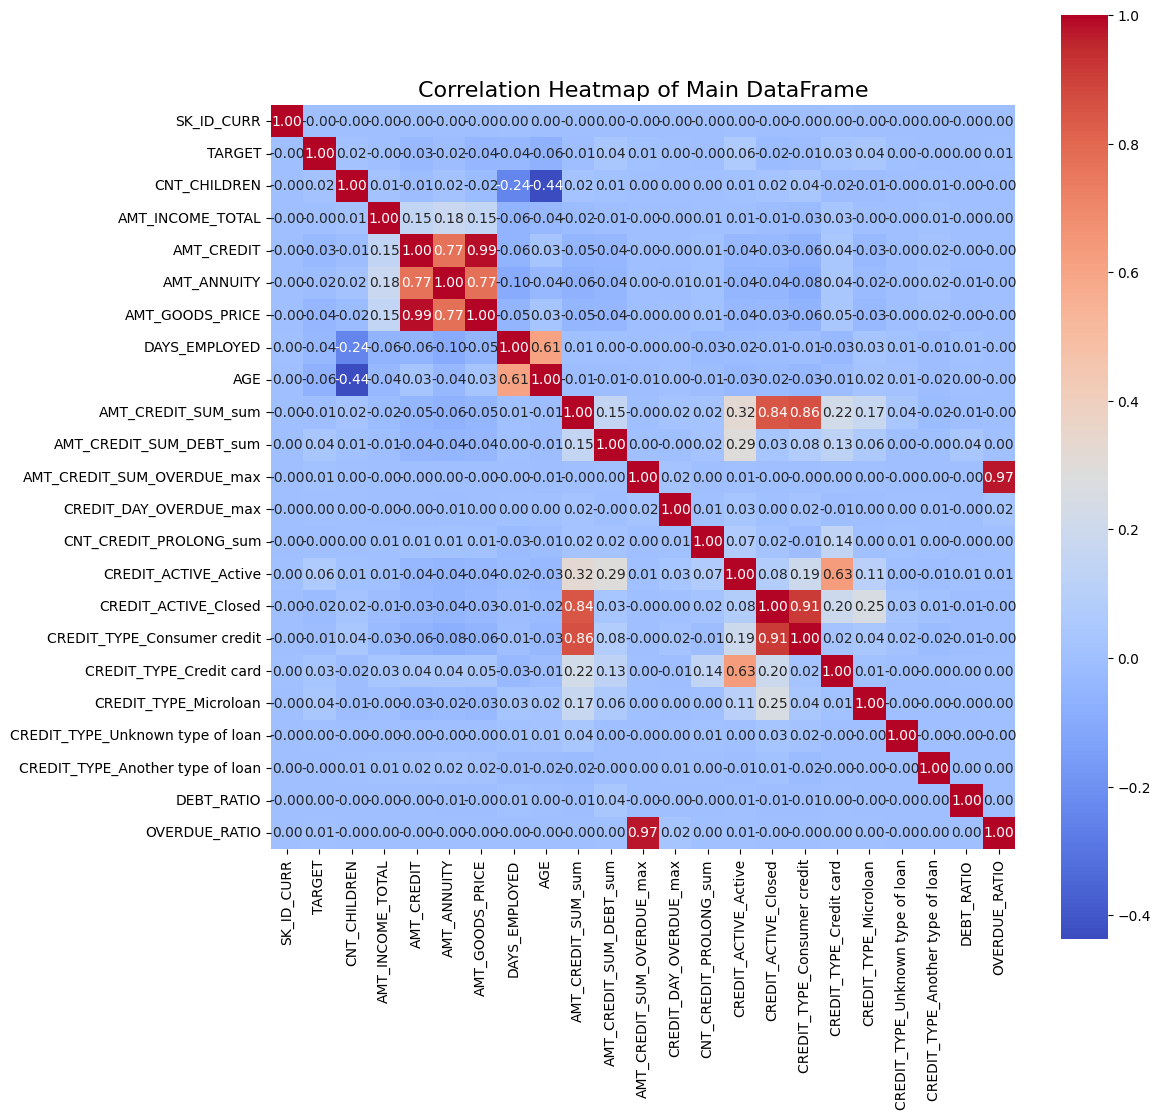

In [79]:
# Compute the correlation matrix
corr = main_df_numeric.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 12))

# Draw the heatmap
sns.heatmap(corr, 
            annot=True,       # show correlation values
            fmt=".2f",        # format to 2 decimal places
            cmap='coolwarm',  # color map
            cbar=True,        # show color bar
            square=True)

plt.title('Correlation Heatmap of Main DataFrame', fontsize=16)
plt.show()


In [ ]:

corr_matrix = main_df_numeric.corr()

# Get upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find pairs where correlation is above 0.5
high_corr = [(col, row, upper.loc[row, col]) 
             for col in upper.columns 
             for row in upper.index 
             if abs(upper.loc[row, col]) > 0.5]

# Convert to a DataFrame for easier viewing
high_corr_df = pd.DataFrame(high_corr, columns=['Column 1', 'Column 2', 'Correlation'])
high_corr_df


,Column 1,Column 2,Correlation
0,AMT_ANNUITY,AMT_CREDIT,0.77
1,AMT_GOODS_PRICE,AMT_CREDIT,0.99
2,AMT_GOODS_PRICE,AMT_ANNUITY,0.77
3,AGE,DAYS_EMPLOYED,0.61
4,CREDIT_ACTIVE_Closed,AMT_CREDIT_SUM_sum,0.84
5,CREDIT_TYPE_Consumer credit,AMT_CREDIT_SUM_sum,0.86
6,CREDIT_TYPE_Consumer credit,CREDIT_ACTIVE_Closed,0.91
7,OVERDUE_RATIO,AMT_CREDIT_SUM_OVERDUE_max,0.97
